 # Poetry Analysis and Generation

For the final project, I decided to work with a [poetry dataset](https://www.kaggle.com/johnhallman/complete-poetryfoundationorg-dataset) on Kaggle, which contains about 15,000 poems of about 3,000 poets from [poetryfoundation](https://www.poetryfoundation.org).  
  
I was interested in what the computer would say about poetry –– in particular, the "styles" of poets: Which poets are similar/different? What is the style of a poet? Can it imitate a poet's style to write new poems? Here, the styles are defined by its formal aspects, such as meters, rhymes, and diction. In the first part of my project, I used unsupervised learning methods to explore the similarity among poets. In the second part, I attempted to "teach" the computer to write poems with the data of a certain poet by extracting poetic features from them and using Markov Chains to generate new poems.

### Overview of the data

I imported the dataset into a Data Frame `poems`. Each row of the data frame contains the content, the title, and the author of a poem. 

In [118]:
import pandas as pd

poems = pd.read_csv('poems.csv')
poems.head()

,Unnamed: 0,Author,Title,Poetry Foundation ID,Content
0,0,Wendy Videlock,!,55489,"Dear Writers, I’m compiling the first in what ..."
1,1,Hailey Leithauser,0,41729,"Philosophic\nin its complex, ovoid emptiness,\..."
2,2,Jody Gladding,1-800-FEAR,57135,We'd like to talk with you about fear t...
3,3,Joseph Brodsky,1 January 1965,56736,The Wise Men will unlearn your name.\nAbove yo...
4,4,Ted Berrigan,3 Pages,51624,For Jack Collom\n10 Things I do Every Day\n\np...


There are 15652 poems in total:

In [119]:
len(poems)

15652

The following series shows the number of poems by each poet:

In [20]:
poems.Author.value_counts()

William Shakespeare      85
Anonymous                82
Alfred, Lord Tennyson    78
Rae Armantrout           62
William Wordsworth       59
                         ..
Tony Gloeggler            1
Dani Couture              1
A. B. Spellman            1
Kirill Medvedev           1
Dorian Merina             1
Name: Author, Length: 3310, dtype: int64

Shakespeare has the largest number of poems in the dataset, which is 85. Meanwhile, there are many less well-known poets of whom only one poem is included in the dataset. It is noteworthy that 82 poems are written by "Anonymous" poets. Later when I grouped the poems by poets and performed clustering, these poems cannot provide any useful information. I do not need to generate poems for anonymous poets either. So I deleted the poems whose authors are unknown.

In [2]:
poems = poems[poems.Author != 'Anonymous'] # delete the poems written by anonymous poets

I also took a look at the lengths of poems: 

In [3]:
poems.Content.map(len).sort_values()

12782        1
6565         1
5741         1
14042        1
10463        1
         ...  
10073    47396
10083    50731
14512    53482
11631    54609
12412    86469
Name: Content, Length: 15570, dtype: int64

It turns out that there is a great range of lengths among these poems. The longest poem contains about 86,000 characters, while there are many single-character poems, which might suggest some errors with the data. I wanted to check what these short poems are like:

In [6]:
ind = poems.Content.map(len).sort_values()[:15].index # get the index of the 15 shortest poems 
poems.loc[ind]

,Unnamed: 0,Author,Title,Poetry Foundation ID,Content
12782,12782,Seamus Heaney,from\n \n \n Squarings\n \n : Lightenings,57045,i
6565,6565,Wallace Stevens,from\n \n The Indigo Glass in the Grass,14574,d
5741,5741,Warsan Shire,The House,90733,i
14042,14042,Gottfried Benn,Tracing,54406,i
10463,10463,Jupiter Hammon,A Poem for Children with Thoughts on Death,52561,I
13079,13079,Wallace Stevens,Sunday Morning,13261,I
3315,3315,Lord ron (George Gordon),"from\n \n \n Don Juan\n \n : Canto 1, St...",55815,47
3313,3313,Lord ron (George Gordon),"from\n \n \n Don Juan\n \n : Canto 1, St...",55816,217
1689,1689,Erasmus Darwin,"from\n \n The Botanic Garden, “The Economy o...",52827,Argument
1921,1921,Todd Boss,Call as You Will,52665,—retracing


Although it is possible for some modern / postmodern poems to consist of a couple of lines or a few words, most of the shortest poems are likely to be incorrect or incomplete data (I have checked some of the original poems). So I decided to delete those poems that have less than 50 characters.

In [4]:
poems = poems[poems.Content.map(lambda x: len(x) >= 50)]

I noticed that more than 1000 of the poems contain \xa0 Unicode representing space. I replaced them with the space ' '.

In [11]:
len(poems[poems.Content.str.contains('\xa0')])

1216

In [14]:
poems['Content'] = poems.Content.map(lambda x: x.replace(u'\xa0', u' '))

## Poets Similarity

  For the first part of my project, I decided to perform dimensionality reduction and clustering on the poems by poets and then create a visualization.  
  
  First of all, I created a Data frame `poets` by joining all the poems of each poet into a long string. Each row of the data frame contains the name of a poet and the content of all of his/her poems.

In [4]:
# create a document for each poet
poets = poems.groupby(poems.Author).Content.agg(lambda x: '\n'.join(x))
poets = poets.reset_index()
poets.head()

,Author,Content
0,'Annah Sobelman,at first she thinks the attraction does ...
1,A. B. Spellman,my swing is more mellow\nthese days: not the h...
2,A. E. Housman,"These, in the days when heaven was falling,\nT..."
3,A. E. Stallings,"The hounds, you know them all by name.\nYou fo..."
4,A. F. Moritz,I wish we could control this revolting\nwant o...


I stored the word counts of the tokenized poems into a new column `Length`.

In [10]:
%%time
import nltk
#tokenizer = nltk.tokenize.TweetTokenizer()
poets['Length'] = poets.Content.map(lambda x: len(nltk.word_tokenize(x)))
poets.sort_values('Length', ascending = False)[:10]

CPU times: user 36.3 s, sys: 177 ms, total: 36.5 s
Wall time: 36.7 s


,Author,Content,Length
1547,John Milton,"Blest pair of Sirens, pledges of Heav'ns joy,\...",119511
2640,Robert Browning,"Would that the structure brave, the manifold m...",42154
79,"Alfred, Lord Tennyson","Break, break, break,\nOn thy cold gray stones,...",41829
3195,Walt Whitman,"Centre of equal daughters, equal sons,\nAll, a...",38265
80,Algernon Charles Swinburne,"after Sappho\nYea, thou shalt be forgotten lik...",36625
2448,Percy sshe Shelley,"I\n\nI weep for Adonais—he is dead!\nOh, weep ...",34508
72,Alexander Pope,"What beck'ning ghost, along the moon-light sha...",33289
3255,William Wordsworth,Who is the happy Warrior? Who is he\nThat ever...,30213
2143,Matthew Arnold,"Through the black, rushing smoke-bursts,\nThic...",28468
3249,William Shakespeare,Let the bird of loudest lay\nOn the sole Arabi...,25712


Above are the 10 poets with the longest poems in the dataset, among which Milton has much longer poems(~120,000 words) than other poets. In fact, the total length of poems by each poet varies greatly from one another. The majority (3/4) of the poets have less than 1,500 words, while least 10 poets have poems longer than 25,000 words. In other words, a large portion of the texts in the dataset is written by a relatively small number of poets. 

In [12]:
poets.Length.describe()

count      3303.00000
mean       1413.25280
std        3397.31776
min           9.00000
25%         200.00000
50%         507.00000
75%        1452.00000
max      119511.00000
Name: Length, dtype: float64

Since there are more than 3000 poets, most of whom have poems of relatively short lengths, I decided to choose 5,000 words as the threshold, i.e. only dealing with the poets whose poems have more than 5,000 words in total. There are about 200 poets like this, which is a reasonable number to visualize.

In [13]:
poets = poets[poets.Length >= 5000]
len(poets)

180

### Dimensionality Reduction

Similar to what we did in the lectures and assignments, I used Truncated Singular Value Decomposition to reduce the dimensions of the matrix and then performed k-means clustering on it. Both methods have the advantage of being able to work with sparse data.
  
First, I used a Tf-idf Vectorizer to create a feature matrix. I included words and bigrams that occur in no more than 80% of the poems since those more frequent ones, including stop words, are not informative of the characteristics of different poets' poems. I considered bigrams in addition to words because I think they can also tell us something about the styles of poets. I set the maximum number of features to 10000 to avoid getting a matrix too large to efficiently work with.

In [14]:
# Tf-Idf vectorization
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1, 2), max_features=10000)
#vect.fit(poets.Content)
#features = vect.transform(poets.Content)
features = vectorizer.fit_transform(poets.Content)
features

<180x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 393497 stored elements in Compressed Sparse Row format>

It gives us a 180 * 10000 matrix where each row represents a document (i.e. the poems of a poet) and each column represents a feature, which is a word or a bigram. Each entry is a tf-idf value that tells us the significance of each word/bigram in each document.  
  
Then I created a TruncatedSVD model to reduce the feature matrix to two-dimensions. The resulting matrix has only two columns, which means there are only two new features for each document.

In [15]:
# Dimensionality reduction with TruncatedSVD
from sklearn import decomposition
svd = decomposition.TruncatedSVD(n_components=2) # reduce to 2 components
svd_features = svd.fit_transform(features)
svd_features.shape

(180, 2)

I added the two columns into the DataFrame as new columns `SVDX` and `SVDY`. I can use them as X and Y coordinates to visualize the positions of the poems on a scatter plot. 

In [16]:
poets["SVDX"] = svd_features[:, 0]
poets["SVDY"] = svd_features[:, 1]
poets.head()

,Author,Content,Length,SVDX,SVDY
55,Alan R. Shapiro,The songs swept down from the northern steppes...,6742,0.468795,-0.185879
58,Albert Goldbarth,"Chile, 1834\n\nA month before his dinner with ...",9972,0.500391,-0.180025
72,Alexander Pope,"What beck'ning ghost, along the moon-light sha...",33266,0.462888,0.419507
75,Alfred Corn,The flexible arc\ndescribed by treetop leaves\...,5328,0.406712,-0.126460
79,"Alfred, Lord Tennyson","Break, break, break,\nOn thy cold gray stones,...",41829,0.501241,0.461783


<IPython.core.display.Javascript object>


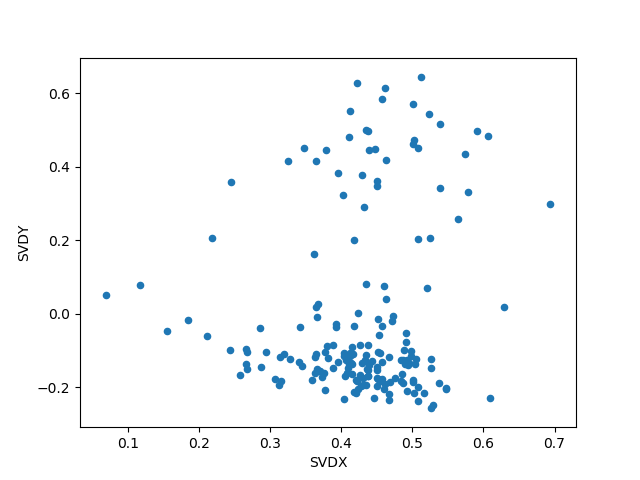

<function __main__.<lambda>(sel)>

In [17]:
%matplotlib notebook
from matplotlib import pyplot
import mplcursors

ax = poets.plot.scatter(x="SVDX", y="SVDY")
cursor = mplcursors.cursor(ax)
cursor.connect('add', lambda sel: sel.annotation.set_text(poets.Author.iloc[sel.target.index]))

Each point represents the poems of each poet. Close points suggest similar styles of the poets. There appears to be a quite obvious cluster at the bottom of the plot and another one at the top. It seems that the position of a poet are related with the the age he/she lived in. 

### Poets Clustering
  
Next, I used k-means clustering method to find the clusters. K-means algorithm requires an input of the number of clusters as parameter `n_clusters`. In order to determine the number I should input, I used the silhouette score to assess the performances of clustering with different inputs of `n_clusters`. I looped through 2 to 9 clusters and calculated the silhouette score of each clustering. 

In [18]:
%%time
# K-means clustering
from sklearn.cluster import KMeans

for n_clust in range(2, 10):
    kmeans = KMeans(n_clusters=n_clust)
    kmeans.fit(features)
    score = sklearn.metrics.silhouette_score(features, kmeans.labels_, metric='euclidean')
    print("With {} clusters, the silhouette score is {:.3f}".format(n_clust, score))

With 2 clusters, the silhouette score is 0.055
With 3 clusters, the silhouette score is 0.064
With 4 clusters, the silhouette score is 0.051
With 5 clusters, the silhouette score is 0.038
With 6 clusters, the silhouette score is 0.022
With 7 clusters, the silhouette score is 0.028
With 8 clusters, the silhouette score is 0.027
With 9 clusters, the silhouette score is 0.027
CPU times: user 3min 58s, sys: 2.92 s, total: 4min 1s
Wall time: 3min 3s


With 3 clusters, the silhouette score is 0.064, which is the highest among all the results above. It means 3 might be the "right" number of clusters that enables each point to be well matched to its own cluster and well separated from other cluters. I set `n_clusters` to 3 and re-ran the clustering. I assigned the resulting labels to a new column `Cluter` in the DataFrame.

In [22]:
%%time
kmeans = sklearn.cluster.KMeans(n_clusters=3)
kmeans.fit(features)
kmeans.predict(features)
poets['Cluster'] = kmeans.labels_
poets.head()

CPU times: user 34.7 s, sys: 452 ms, total: 35.2 s
Wall time: 27.1 s


,Author,Content,Length,SVDX,SVDY,Cluster
55,Alan R. Shapiro,The songs swept down from the northern steppes...,6742,0.468795,-0.185879,2
58,Albert Goldbarth,"Chile, 1834\n\nA month before his dinner with ...",9972,0.500391,-0.180025,2
72,Alexander Pope,"What beck'ning ghost, along the moon-light sha...",33266,0.462888,0.419507,0
75,Alfred Corn,The flexible arc\ndescribed by treetop leaves\...,5328,0.406712,-0.126460,2
79,"Alfred, Lord Tennyson","Break, break, break,\nOn thy cold gray stones,...",41829,0.501241,0.461783,0


I made a scatter plot to visualize the clusters. Each point is colored according to its label.

<IPython.core.display.Javascript object>


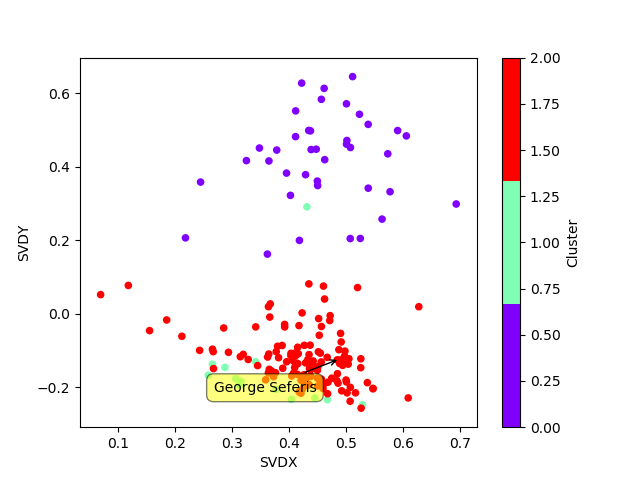

<function __main__.<lambda>(sel)>

In [50]:
%matplotlib notebook
ax = poets.plot.scatter(x="SVDX", y="SVDY", c="Cluster", colormap=pyplot.get_cmap("rainbow", 3))
cursor = mplcursors.cursor(ax)
cursor.connect('add', lambda sel: sel.annotation.set_text(poets.Author.iloc[sel.target.index]))

Generally, the three clusters match quite well with the dimensionality reduction result. After clicking some of the points and observing the results, I discovered that the purple points are mostly canonical poets from the 16-19th Century, such as Shakespeare and Wordsworth, while the rest are mainly modern and contemporary poets from the late nineteenth century to the twenty-first century. It is more difficult to tell the difference between the red and green clusters, especially since I am not familiar with many of these poets. One conjecture is that the green points represent the contemporary poets whose writings are more experimental and diverge from typical poems. There are also a few points that seem to be falsely clustered, such as Chaucer marked as red, and William Blake marked as green. 
  
  
  The result shows that poets are grouped based on the times. The "styles" here are more associated with the different usages of words and word combinations by poets at different times. If we want to see more specific differences concerning genres, forms, or themes, it would be interesting to perform the clustering with the poets of the same age.

## Poetry Generation

In this section, I used Markov Chains to generate poems that have the styles of a certain poet. Before that, I needed to decide the metrical patterns and rhyme schemes of the poet's poems so that I can apply them to the poetry generation.   
  
I selected Milton's poems, which are the longest in the dataset. His poems are known as "blank verse," which means poems written in unrhymed iambic pentameter. Later in the exploration of his poetic style, I can access the result with this piece of information.  

I split the long string of poems into lines and created a DataFrame to store each line as a row. I deleted the lines with less than five characters, which are mostly blank lines or information like dates that is not a line of poems itself.

In [5]:
milton = poets[poets.Author == 'John Milton'].Content.values[0]
milton[:50]

"Blest pair of Sirens, pledges of Heav'ns joy,\nSphe"

In [6]:
df = pd.DataFrame({'lines': milton.split('\n')})
df = df[df.lines.map(len) > 5] # drop lines that have five or less characters
df

,lines
0,"Blest pair of Sirens, pledges of Heav'ns joy,"
1,"Sphear-born harmonious Sisters, Voice, and Vers,"
2,"Wed your divine sounds, and mixt power employ"
3,"Dead things with inbreath'd sense able to pierce,"
4,"And to our high-rais'd phantasie present,"
...,...
13620,It shall be still in strictest measure ev'n
13621,"To that same lot, however mean or high,"
13622,"Toward which Time leads me, and the will of He..."
13623,"All is, if I have grace to use it so"


### Meter

The meter of a verse can be described as a sequence of feet, each foot being a specific sequence of syllable types — such as relatively unstressed/stressed (the iambic foot). In my project, I considered two aspects: the numbers of syllables and the stress patterns of lines.  

To determine the metrical patterns, I used [CMUDict](http://www.speech.cs.cmu.edu/cgi-bin/cmudict) which contains over 134,000 words and their pronunciations. For each word in a line, I can use its pronunciation information in the CMUDict to extract the vowels, with which I can count the number of syllables. At the end of vowels, there are stress markers that I can use to detect stress patterns. However, many of the words in the poems are not included in the dictionary. Among these words, there are mainly two types: 1) possessive forms of nouns; 2) archaic spelling of words, such as "Heav'n" and "flow'ry".   

For the first situation, I decided to remove the "'s" in the word. The second one is more difficult to deal with since various situations require different ways to address. For instance, many words contain apostrophes that replace a letter, yet there are at least three different usages we can consider respectively depending on where the apostrophe occurs in the word and what letter it stands for. I chose not to deal with each situation so that the process would not be unnecessarily complicated and detailed. Instead, I only considered the most common case where the apostrophes are used in place of the letter "e". So I simply replaced all occurrences of apostrophes with "e" after I deleted all "'s".   


These two steps can transform many unrecognized words into their original forms that are included in CMUDict. Nevertheless, there are still some words that cannot be found since they are spelled in more irregular ways. I had tried to implement a spellchecker that finds a word most similar to the input one by calculating the edit distance. It can successfully find the correct words sometimes; but this method took a very long time to run, especially when applied to all data. Considering the inefficiency, I eventually decided to simply skip these words and mark them as None. Given a large amount of data, discarding lines containing these unrecognized words would not have a significant influence.   

/
So I did what was mentioned above with a function vowels(). It removes "'s," replaces other apostrophes with "e" and converts the word to the lower case. Then it checks whether the regularized word can be found in CMUDict. If not found, the word is marked as None; if there is available information in the dictionary, it returns a list of all vowels in the word. The numbers are dropped here since I do not need the stress markers until the next section. Some words have more than one pronunciation. But here I only consider the first one on the list. Usually, different pronunciations of a word vary in the stress or the vowel sound; the total number of syllables is not affected.

In [7]:
from nltk.corpus import cmudict
cmu = cmudict.dict()

# define a function that returns the vowels in a word
def vowels(word):
    word = word.replace("'s", '') # removed "'s" from possessive nouns
    word = word.replace("'", "e") # replace "'" with "e"
    word = word.lower()
    
    if word in cmu:
        vow = [x[:-1] for x in cmu[word][0] if x[-1].isdigit()] # extract the vowel syllables from the pronunciation
        return(vow)
    else:
        return None # if the word is not in CMUDict, mark as None

In [56]:
vowels("Heav'n")

['EH', 'AH']

I tested the function with the word "Heav'n" and it correctly returned a list of the vowels in it. 
  
Then I tokenized the original poems and cleaned them by removing punctuations and converting all words to lower cases. I stored the results in a new column `cleaned`. Then I used the function `vowels()` to find the vowels for each word in a line and applied the procedure to all lines. I created a column `vowels`, where each row contains a list of the vowels lists for all words in each line. 

In [10]:
df['lines'] = df['lines'].map(lambda x: x.replace('-', ' ')) # expand compound words by replacing '-' with space
df['cleaned'] = df.lines.map(
                    lambda x: [tok.lower() for tok in nltk.word_tokenize(x) if tok.upper().isupper()] # exclude punctuations
                ) 
df['vowels'] = df.cleaned.map(
                    lambda x: [vowels(word) for word in x]
                )
df.head() 

,lines,cleaned,vowels
0,"Blest pair of Sirens, pledges of Heav'ns joy,","[blest, pair, of, sirens, pledges, of, heav'ns...","[[EH], [EH], [AH], [AY, AH], [EH, IH], [AH], [..."
1,"Sphear born harmonious Sisters, Voice, and Vers,","[sphear, born, harmonious, sisters, voice, and...","[None, [AO], [AA, OW, IY, AH], [IH, ER], [OY],..."
2,"Wed your divine sounds, and mixt power employ","[wed, your, divine, sounds, and, mixt, power, ...","[[EH], [AO], [IH, AY], [AW], [AH], None, [AW, ..."
3,"Dead things with inbreath'd sense able to pierce,","[dead, things, with, inbreath, 'd, sense, able...","[[EH], [IH], [IH], None, [EH], [EH], [EY, AH],..."
4,"And to our high rais'd phantasie present,","[and, to, our, high, rais, 'd, phantasie, pres...","[[AH], [UW], [AW, ER], [AY], [EY], [EH], None,..."


In [29]:
df.vowels.map(lambda x: None in x).sum()

6913

There are 6913 out of 13263 lines that contain unrecognized words, which are marked as `None`. Although it appears to be a quite large proportion, there are still more than 7,000 lines left, which is sufficiently large for counting the number of syllables. 

#### Count  Syllables

I dropped the lines with unrecognized words and created a new DataFrame `valid_lines` with the rest of lines. I counted the number of vowels in each line and stored them in the column `n_syllables`. I also deleted the lines with less than six syllables and less than three words because I noticed some errors in these lines. 

In [11]:
valid_lines = df[df.vowels.map(lambda x: None not in x)] # delete lines that contains None
valid_lines['n_syllables'] = valid_lines.vowels.map(lambda x: sum([len(word) for word in x]))
# delete lines that have less than five syllables (usually wrong info)
valid_lines = valid_lines[(valid_lines.n_syllables > 5) & (valid_lines.cleaned.map(len) >= 3)] 
valid_lines

//anaconda3/envs/Ling110/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lines,cleaned,vowels,n_syllables
0,"Blest pair of Sirens, pledges of Heav'ns joy,","[blest, pair, of, sirens, pledges, of, heav'ns...","[[EH], [EH], [AH], [AY, AH], [EH, IH], [AH], [...",11
7,To him that sits theron,"[to, him, that, sits, theron]","[[UW], [IH], [AE], [IH], [EH, AH]]",6
10,"Their loud up lifted Angel trumpets blow,","[their, loud, up, lifted, angel, trumpets, blow]","[[EH], [AW], [AH], [IH, AH], [EY, AH], [AH, AH...",10
12,"Touch their immortal Harps of golden wires,","[touch, their, immortal, harps, of, golden, wi...","[[AH], [EH], [IH, AO, AH], [AA], [AH], [OW, AH...",11
13,With those just Spirits that wear victorious P...,"[with, those, just, spirits, that, wear, victo...","[[IH], [OW], [AH], [IH, AH], [AE], [EH], [IH, ...",12
...,...,...,...,...
13615,Perhaps my semblance might deceive the truth,"[perhaps, my, semblance, might, deceive, the, ...","[[ER, AE], [AY], [EH, AH], [AY], [IH, IY], [AH...",10
13619,"Yet be it less or more, or soon or slow,","[yet, be, it, less, or, more, or, soon, or, slow]","[[EH], [IY], [IH], [EH], [AO], [AO], [AO], [UW...",10
13620,It shall be still in strictest measure ev'n,"[it, shall, be, still, in, strictest, measure,...","[[IH], [AE], [IY], [IH], [IH], [IH, AH], [EH, ...",11
13621,"To that same lot, however mean or high,","[to, that, same, lot, however, mean, or, high]","[[UW], [AE], [EY], [AA], [AW, EH, ER], [IY], [...",10


While the counts range from 6 to 17, 63% of the lines have 10 syllables. It corresponds with our knowledge of his poems as mostly pentameter. Although it seems reasonable to simply generate every line with 10 syllables, poems of other poets, especially the modern ones, are likely to vary more significantly in their syllable counts of each line. I decided to use the frequencies the possible numbers occur as the possibility to randomly choose a number as the syllable counts for each new line.

In [23]:
valid_lines.n_syllables.value_counts()

10    4014
11    1548
12     351
8      138
6       82
9       80
7       63
13      55
14       7
15       2
17       1
Name: n_syllables, dtype: int64

In [12]:
n_syl = valid_lines.n_syllables.unique() # possible number of syllables per line
p = [] # proportions of each number of syllables
for n in n_syl:
    p.append(len(valid_lines[valid_lines.n_syllables == n])/len(valid_lines))
n_syl, p

(array([11,  6, 10, 12,  7,  9,  8, 13, 15, 14, 17]),
 [0.24412553225043368,
  0.012931714240656048,
  0.6330231824633339,
  0.05535404510329601,
  0.009935341428796719,
  0.012616306576249802,
  0.02176312884403091,
  0.008673710771171739,
  0.00031540766440624505,
  0.0011039268254218577,
  0.00015770383220312253])

In [13]:
import numpy as np
import random
np.random.choice(n_syl, p = p) # choose a random number from the list with p as possibility

11

#### Stress patterns

CMUDict includes numbers 0,1,2 as stress markers at the end of the vowels:
* 0: No stress
* 1: Primary stress
* 2: Secondary stress  
  
I can use this information to find the stress patterns of lines. I wrote a function `stress()` that returns the stress markers in the input word. Similar to `vowels()`, it regularizes the word before looking for its pronunciation in the CMU dictionary. Since I can directly use the DataFrame from above that does not include lines with unidentified words, I assumed all words the function encounter can be found in the dictionary.   
  
  There are three different stress markers here. Because we usually define feet as stressed/unstressed combinations, I decided to take both '0' and '2' as no stress and '1' as stress. For words with more than one pronunciation, the function loops through each one and checks whether there is an unstressed syllable('0' or '2' at the end of any phoneme). The first pronunciation with unstressed syllables is considered and the loop stops once it appears. If the word has a stressed syllable only, the first pronunciation is chosen. Eventually, the function returns a string of the stress markers in the chosen pronunciation with the secondary stress ('2') denoted as no stress ('0'). So the output string consists of only "0" and "1"

In [14]:
def stress(word):
    word = word.replace("'s", '') # removed "'s" from possessive nouns
    word = word.replace("'", "e") # replace "'" with "e"
    word = word.lower() # convert to lower case
    
    stress = 1 # becomes 0 if encounter unstressed syllable
    
    # find the first pronunciation with unstressed syllables '0' or '2'
    for pron in cmu[word]:
        # the loop stops if unstress syllables are found
        if stress == 1:
            for phoneme in pron:
                # check whether there are any '0'/'2'
                if ('0' in phoneme) | ('2' in phoneme):
                    stress = 0 
                    pronunciation = pron
                else:
                    pass
        else:
            break
    # if no unstressed syllables, use the first pronunciation
    if stress == 1:
        pronunciation = cmu[word][0]
        
    # extract the stress markers from the word pronunciation
    # mark both "0" and "2" as "0"
    stress = ['0' if (x[-1]=='0')|(x[-1]=='2') else '1' for x in pronunciation if x[-1].isdigit()]
    return(''.join(stress))

In [329]:
print(cmu['and'], '\nStress pattern:', stress('and'))

[['AH0', 'N', 'D'], ['AE1', 'N', 'D']] 
Stress pattern: 0


The word "and" has two pronunciations. The function chooses the one without stress and returns the marker '0'.  
  
I mapped the function to each row. The most common two types of feet –– iamb (unstressed/stressed) and trochee (stressed/unstressed) –– are two-syllable units. So I needed to look at the stress in two-syllable units too. After joining all the stress markers to a string for each line, I splitted it into two-character segments. 

In [15]:
%%time
valid_lines['stress'] = valid_lines.cleaned.map(
                        lambda x: [stress(word) for word in x]).map( # get stress patterns for all words in each line
                        ''.join).map(                                # join the patterns into a string
                        lambda x: [x[i:i + 2] for i in range(0, len(x), 2)] # split into 2-character unit
                )
valid_lines.head()

CPU times: user 183 ms, sys: 5.54 ms, total: 188 ms
Wall time: 190 ms


,lines,cleaned,vowels,n_syllables,stress
0,"Blest pair of Sirens, pledges of Heav'ns joy,","[blest, pair, of, sirens, pledges, of, heav'ns...","[[EH], [EH], [AH], [AY, AH], [EH, IH], [AH], [...",11,"[11, 01, 01, 00, 10, 1]"
7,To him that sits theron,"[to, him, that, sits, theron]","[[UW], [IH], [AE], [IH], [EH, AH]]",6,"[00, 01, 10]"
10,"Their loud up lifted Angel trumpets blow,","[their, loud, up, lifted, angel, trumpets, blow]","[[EH], [AW], [AH], [IH, AH], [EY, AH], [AH, AH...",10,"[11, 11, 01, 01, 01]"
12,"Touch their immortal Harps of golden wires,","[touch, their, immortal, harps, of, golden, wi...","[[AH], [EH], [IH, AO, AH], [AA], [AH], [OW, AH...",11,"[11, 01, 01, 01, 01, 0]"
13,With those just Spirits that wear victorious P...,"[with, those, just, spirits, that, wear, victo...","[[IH], [OW], [AH], [IH, AH], [AE], [EH], [IH, ...",12,"[01, 01, 00, 10, 10, 01]"


Since I only considered iambic ("01") and trochaic ("10") feet, I calculated the freqeuncy they occur in all poems to see which one is more common. If both of these two feet are infrequent, the poems probably do not follow the usual stress patterns.

In [45]:
for i in ['01','10']:
    total = valid_lines.stress.map(len).sum() # sum up the numbers of syllables for all lines
    feet = valid_lines.stress.map(lambda x: x.count(i)).sum() # the total number of iambic/trochaic feet
    print(feet/total) # return the frequency

0.47744754721498905
0.12328275118972794


48% of all feet are iambic and 12% are trochaic. The rest (40%) do not fall into either of these two; they could be "00" "11" "0" or "1". The proportion of iambic feet is slightly smaller than I expected. Indeed, the methods I took determined that the results can contain some inaccuracies. For instance, I considered all secondary stress as no stress and simply used the first pronunciation that contains unstressed syllables. Sometimes a word may actually be pronounced as stressed in a line, even though it has an alternative pronunciation as an unstressed syllable. Many uncertain cases largely depend on the contexts. Since the algorithm is not flexible enough to use different methods in different contexts, there could some mishandled syllables in the result. Besides, I simply divided every line into 2-syllable units and ignored potential three-syllable feet. For a line with an odd number of syllables, the last unit has only one syllable left, which is not a "foot" at all.  

Although inaccuracy also exists in other steps, here it can have considerable influence on the results. For example, a poet uses mostly iambic feet, yet my method may find a smaller proportion of them than the actual one. If there are more feet labeled as neither iambic nor trochaic, the poem will be considered as a free verse that does not employ any stress patterns. In such a case, it fails to extract the stress patterns. Here although iambs ("01") are more frequent than other types, they are still less than half of all the feet.   

Another concern is that if I try to generate poems where each line is strictly iambic ("01"), there may be very limited word choices. Since I cannot come up with better methods to deal with the stress so far, I did not apply the stress patterns to poetry generation.  

#### Rhyme Schemes

Since there are numerous possible combinations of rhymes, it would be difficult to track the rhyme schemes of all poems accurately. To simplify the situation, I only considered the rhymes of every four lines. I grouped the lines into four-line chunks and denoted the ending syllables with letters (e.g. AABB). The same letters represent the same syllables. If in any of the four lines the ending syllable is "None", I would discard the chunk. Then I can extract the most common combination as the rhyme scheme to generate poems. If there are no recognizable rhyme schemes (i.e. ABCD) the poems are considered as unrhymed.   
  
For the first step, I wrote a function that combines every four rows into one row and applied it to the DataFrame `df`. The transformed DataFrame is called `new_df`, where each row contains a four-line chunk.

In [16]:
def chunks(df):
    l = [df.vowels.values[i : i+4] for i in range(0, len(df), 4)]
    new_df = pd.DataFrame({'vowels': l})
    return(new_df)

new_df = chunks(df)
new_df.head()

,vowels
0,"[[[EH], [EH], [AH], [AY, AH], [EH, IH], [AH], ..."
1,"[[[AH], [UW], [AW, ER], [AY], [EY], [EH], None..."
2,"[[[IH], [EY, IY], [AW], [AH], [AA, AH], None],..."
3,"[[[AH], [EH], [IH, AO, AH], [AA], [AH], [OW, A..."
4,"[[[AE], [IY], [AA], [ER], [IH], None, [OY]], [..."


Then I deleted the chunks that contain unrecognized words `None` at the end of one or more lines. 

In [17]:
n = new_df.vowels.map(lambda x: [None for i in x if i[-1] == None]) # show which lines have None at the end 
n = n.map(len)
new_df.drop(n[n > 0].index, inplace = True) # drop those rows(chunks) which contain None at the end of any lines
new_df

,vowels
0,"[[[EH], [EH], [AH], [AY, AH], [EH, IH], [AH], ..."
1,"[[[AH], [UW], [AW, ER], [AY], [EY], [EH], None..."
4,"[[[AE], [IY], [AA], [ER], [IH], None, [OY]], [..."
5,"[[[OW], [AH], [EH], [UW, IH], [AE], [AO], [IY,..."
6,"[[[OW], [EY], [IY], [UW], [AH, EH], [IH, UW], ..."
...,...
3309,"[[[AO], [UW], [IY], [AY], None, [AH], [AH], [E..."
3310,"[[[UH, AH, AH, EY, AH], [IH], [AH], [OW], [AO]..."
3311,"[[[ER], [EY], [AA], [EY], [EH], [EH], [UW], [A..."
3312,"[[[AY], None, [EH], [IY], [EH], [AH], [EY], [A..."


Even though we can still see `None` in the DataFrame, they do not have any influence since I only needed to consider the ending syllable at each line.  Now there are 1951 chunks, each of which contains four consecutive lines where the ending syllables are all available. I can use them to detect the rhyme schemes.  
  
I defined a function `rhyme_scheme()` to find the rhyme scheme of the input chunk. It loops through each line in the chunk and looks at its last vowel. Every time a new vowel appears, it is denoted with a new letter from "A" "B" "C" "D" in order. Two values are returned: a list of the ending vowels and a string of letters representing the rhyme schemes

In [18]:
# extract the rhyme schemes from a chunk
def rhyme_scheme(chunk):
    alpha = 'ABCD' # letters I can choose from
    vow_list = []
    rhyme_scheme = ''
    i=-1
    for line in chunk:
        vow = line[-1][-1] # the last vowel of the line
        # use a new letter for a new vowel
        if vow not in vow_list:
            i += 1
            rhyme_scheme += alpha[i]
        else:
            r = vow_list.index(vow)
            rhyme_scheme += rhyme_scheme[r]
        vow_list.append(vow)
    return(vow_list, rhyme_scheme)

In [324]:
rhyme_scheme(new_df.vowels[0])

(['OY', 'ER', 'OY', 'IH'], 'ABAC')

I mapped the function to `new_df` and stored the two outputs in new columns `rhyme` and `rhyme_scheme` respectively.

In [19]:
new_df['rhyme'] = new_df.vowels.map(lambda x: rhyme_scheme(x)[0])
new_df['rhyme_scheme'] = new_df.vowels.map(lambda x: rhyme_scheme(x)[1])
new_df

,vowels,rhyme,rhyme_scheme
0,"[[[EH], [EH], [AH], [AY, AH], [EH, IH], [AH], ...","[OY, ER, OY, IH]",ABAC
1,"[[[AH], [UW], [AW, ER], [AY], [EY], [EH], None...","[AH, EH, OW, AH]",ABCA
4,"[[[AE], [IY], [AA], [ER], [IH], None, [OY]], [...","[OY, OY, IH, IH]",AABB
5,"[[[OW], [AH], [EH], [UW, IH], [AE], [AO], [IY,...","[EY, IY, UH, UH]",ABCC
6,"[[[OW], [EY], [IY], [UW], [AH, EH], [IH, UW], ...","[AO, AO, AY, AY]",AABB
...,...,...,...
3309,"[[[AO], [UW], [IY], [AY], None, [AH], [AH], [E...","[EY, EY, EY, EY]",AAAA
3310,"[[[UH, AH, AH, EY, AH], [IH], [AH], [OW], [AO]...","[EY, AE, EY, AY]",ABAC
3311,"[[[ER], [EY], [AA], [EY], [EH], [EH], [UW], [A...","[AY, EH, AY, EH]",ABAB
3312,"[[[AY], None, [EH], [IY], [EH], [AH], [EY], [A...","[AY, UW, IH, IH]",ABCC


I made a bar plot of the column `rhyme_scheme`:

<IPython.core.display.Javascript object>


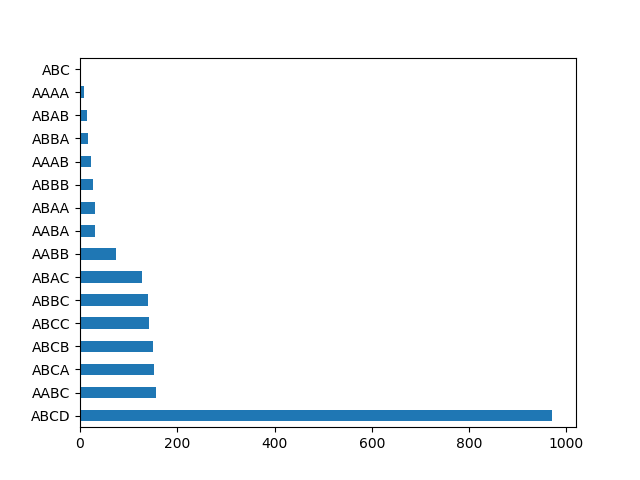

In [326]:
%matplotlib notebook
new_df.rhyme_scheme.value_counts().plot(kind = 'barh')

I decided to use the most common one as the rhyme scheme for the poet. In this case, the majority of Milton's poems are ABCD, so his poems as considered as unrhymed. This result corresponds to the information we have about Milton, whose poems are mostly written in blank verse.

In [20]:
rhyme_sch = new_df.rhyme_scheme.value_counts().index[0]
rhyme_sch

'ABCD'

It is a crude method by considering rhymes for every four lines. There are some other rhyme schemes that are failed to be considered. For instance, it will not work very well with sonnets, whose rhyme schemes are mostly "ABAB CDCD EFEF GG" (Shakespearean) or "ABBA ABBA CDE CDE" (Petrarchan). It also has the problem of mixing different poems together as a whole. But at least in this case, it works efficiently in finding the rhyme schemes.

### Markov Chains

I have extracted information about the meter and the rhyme scheme of Milton's poems. Now I can use his poems to generate new poems that follow the patterns I discovered. Similar to the method we used in Assignment 2, I used Markov Chains for the poetry generation. The main idea is to find the probabilities of each bigram following each other word and every time a word is picked based on the previous bigram. If there are not enough word choices, I would only look at the previous word and from the ones that follow it choose a new word. If there are still not enough words to choose from, I randomly pick a word regardless of what comes before it.  
  
I tokenized the original poems of Milton and excluded some punctuations that are not expected to appear in the generated poems, including "'d". 

In [21]:
# tokenize the string of poems
milton = nltk.word_tokenize(milton)
milton = [x for x in milton if x not in "&[]()''‘’\"”“'d"]
milton[:10]

['Blest', 'pair', 'of', 'Sirens', ',', 'pledges', 'of', "Heav'ns", 'joy', ',']

I used `ngram()` to built a list of dictionary that includes ngrams with sizes from 0 to 2 and the words that follow each ngram.

In [22]:
def ngram(toks):
    grams = []
    for i in range(3):
        for gram in nltk.ngrams(toks, i+1):
            dic = {}
            dic["Size"] = i
            dic["Gram"] = gram[:-1]
            dic['Word']= gram[-1]
            grams.append(dic)
    return(grams)
grams = ngram(milton)
grams[:5]

[{'Size': 0, 'Gram': (), 'Word': 'Blest'},
 {'Size': 0, 'Gram': (), 'Word': 'pair'},
 {'Size': 0, 'Gram': (), 'Word': 'of'},
 {'Size': 0, 'Gram': (), 'Word': 'Sirens'},
 {'Size': 0, 'Gram': (), 'Word': ','}]

Then I converted this into a DataFrame where each row corresponds to one dictionary from above. I also added a column `Rhyme` that stores the last vowels of the words using the function `vowels()`.

In [23]:
df = pd.DataFrame(grams)
df['Rhyme'] = df.Word.map(vowels)
df['Rhyme'] = df['Rhyme'].map(lambda x: x[-1] if x is not None else x)
df.head()

,Size,Gram,Word,Rhyme
0,0,(),Blest,EH
1,0,(),pair,EH
2,0,(),of,AH
3,0,(),Sirens,AH
4,0,(),",",None


I grouped the DataFrame by the first three columns. The new series `grouped_grams` shows the possibilities for each words to occur in a given context in Milton's poems, and the number of times it occurred. 

In [24]:
grouped_grams = df.groupby(['Size','Gram','Word']).size()
grouped_grams

Size  Gram                 Word   
0     ()                   !          64
                           'Less       1
                           'Mongst     1
                           'T          1
                           'Twixt      2
                                      ..
2     (Ænon, ,)            and         1
      (Æolian, charms)     and         1
      (Æthereal, Thrones)  ,           1
      (Ætherial, ,)        who         1
      (Ætherial, Powers)   ,           1
Length: 195036, dtype: int64

I created another series that grouped the words by the last vowel so that I can find rhyming words with a certain ending vowel, although rhyming schemes will not be considered for Milton's poems.

In [25]:
rhyme_grams = df.groupby(['Size','Gram','Rhyme','Word']).size()
rhyme_grams

Size  Gram              Rhyme  Word   
0     ()                AA     Ah         4
                               Antioch    1
                               Arch       4
                               Arched     1
                               Arcs       1
                                         ..
2     (Ægean, shore)    AH     a          1
      (Æmilian, ,)      AH     some       1
      (Ænon, ,)         AH     and        1
      (Æolian, charms)  AH     and        1
      (Ætherial, ,)     UW     who        1
Length: 149719, dtype: int64

I recycled code from Assignment 2 to create a function that implements the backoff method to return a word based on the last bigram. I set the backoff threshold as three. Each time the function uses the input bigram to find words that follow it. If there are less than three candidates in the words pool, it uses the last word in the bigram instead. If the threshold is still not met, it uses no word and randomly picks a word.

In [83]:
def backoff(grouped_grams, word1, word2):
    #global grouped_grams, word1, word2
    gram = (word1, word2)
    gram_size = len(gram)
    
    while True:
        # check if gram is available in index
        if gram in grouped_grams.index.levels[1]:
            words_pool = grouped_grams.loc[gram_size, gram]
        else:
            # if it isn't, set candidates to empty
            words_pool = []
        # if we have enough candidates, stop the trimming loop
        if len(words_pool) >= 3:
            break
        else:
            # not enough candidates, back off and take the last part of the gram
            gram = gram[1:]
            gram_size -= 1
            
    choice = words_pool.sample(weights=words_pool).index[0]
    return(choice)

I imported spacy to check whether a token is a punctuation.

In [27]:
import spacy
nlp = spacy.load('en_core_web_md')

The function below generates a line of poem. Each time it randomly chooses a number from the syllable counts `n_syl` previously calculated and it keeps picking words using `backoff()` until the number is reached. Then it checks whether the first token of the line is a punctuation. If so, the line is discarded and the process restarts to generate a new line. Since Milton's poems do not emply rhyme schemes, I did not consider the ending vowels of lines here.

In [98]:
def write_line():
    global word1, word2, wordlist, n_syl, p
    gram = [word1, word2]
    
    syllable_count = np.random.choice(n_syl, p = p) # random number of syllables as the target for each line
    punct_flag = 0 # check whether the line begins with a punctuation
    
    while punct_flag == 0 : # rewrite the line if the first word is a punctuation
        syl = 0 # current number of syllables in this line
        while syl < syllable_count:  # keep picking words until the syllable count hits the chosen number
            word = backoff(grouped_grams, word1, word2)  # choose a new word
            if (not nlp(word)[0].is_punct) & (vowels(word) is None): # if the word is not in CMUDict, go back and choose a new word
                pass
            else: # otherwise add it to the word list
                wordlist.append(word)
                word1 = word2
                word2 = word
                if not nlp(word)[0].is_punct: # count the syllables in the word
                    syl += len(vowels(word))
                else:
                    pass
            
        if not nlp(wordlist[0])[0].is_punct: # stop the loop if the first is not punct
            punct_flag = 1
        else: # otherwise, regenerate a line
            punct_flag = 0
            word1 = gram[0] #use the last bigram from the previous line
            word2 = gram[1]
            wordlist=[]
    
    wordlist.append('\n') # reach the end of the line
    return(' '.join(wordlist))

Now I needed a function to write a poem that consists of the input number of lines. It uses the last two words of each line as the starting words for the next line. 

In [99]:
def write_poem(nlines):
    global wordlist, word1, word2
    poem = []
    
    for i in range(nlines):
        new_line = write_line()
        tok = nltk.word_tokenize(new_line)
        if len(tok) >= 2: # more than two words in the new line
            poem.append(new_line)
            # use the last two words in the new line as the bigram 
            word1 = tok[-2] 
            word2 = tok[-1]
        else:
            pass
        wordlist = []
        
    return(poem)

There is one last thing I needed in order to generate poems: a starting bigram to start the process. I found all the bigrams that begin with capital letters in the poems and each time I can randomly choose one as the initial bigram to start the generation.

In [79]:
# get all the bigrams 
bigram = df[df.Size == 2].Gram.unique()
# get the bigrams that start with capital letters
capital_gram = [i for i in bigram if i[0][0].isupper()]
capital_gram[:10]

[('Blest', 'pair'),
 ('Sirens', ','),
 ("Heav'ns", 'joy'),
 ('Sphear-born', 'harmonious'),
 ('Sisters', ','),
 ('Voice', ','),
 ('Vers', ','),
 ('Wed', 'your'),
 ('Dead', 'things'),
 ('And', 'to')]

I tried generating an eight-line poem:

In [102]:
%%time
wordlist = list(random.choice(capital_gram)) # start with a random bigram that starts with a capital letter
word1 = wordlist[0]
word2 = wordlist[1]
for i in write_poem(8):
    print(i)

The multitude , like in acts of future life the Ocean 

barr'd create , in foresight , pledges first grand 

foes a Rock Over the foaming 

Steed unrein let us bend thine , and from the bottom 

turn not , Herb yielding Consent Secure throng 

Of various persons then aggravate 

my Merit and shown think the Air those elect 

Bind To thy transgressions Wood , and amber And 

CPU times: user 4.71 s, sys: 88.6 ms, total: 4.8 s
Wall time: 2.5 s


The generated poem uses the words/bigrams and poetic features Milton uses in his poems. So this is roughly what Milton's poems formally look like. Due to the nature of Markov Chain, I couldn't make sure the verse makes sense as a whole. Many of the lines do not follow grammatical rules.

I wanted to try the same thing on other poets. Here I coverted all the previous procedures to functions and applied them to Shakepeare's poems.

In [103]:
def get_poet(poet):
    poet = poets[poets.Author.str.contains(poet)].Content.values[0]
    df = pd.DataFrame({'lines': poet.split('\n')})#[:500]
    df = df[df.lines.map(len) > 5] # drop lines that have five or less characters
    df['lines'] = df['lines'].map(lambda x: x.replace('-', ' '))
    df['cleaned'] = df.lines.map(
                    lambda x: [tok.lower() for tok in nltk.word_tokenize(x) if tok.lower().islower()] # exclude punctuations
                ) 
    df['vowels'] = df.cleaned.map(lambda x: [vowels(word) for word in x])
    return(poet, df)

poet, df = get_poet('Shakespeare')
df.head()

,lines,cleaned,vowels
0,Let the bird of loudest lay,"[let, the, bird, of, loudest, lay]","[[EH], [AH], [ER], [AH], [AW, AH], [EY]]"
1,On the sole Arabian tree,"[on, the, sole, arabian, tree]","[[AA], [AH], [OW], [ER, EY, IY, AH], [IY]]"
2,"Herald sad and trumpet be,","[herald, sad, and, trumpet, be]","[[EH, AH], [AE], [AH], [AH, AH], [IY]]"
3,To whose sound chaste wings obey.,"[to, whose, sound, chaste, wings, obey]","[[UW], [UW], [AW], [EY], [IH], [OW, EY]]"
5,"But thou shrieking harbinger,","[but, thou, shrieking, harbinger]","[[AH], [AW], [IY, IH], [AA, IH, ER]]"


Number of syllables:

In [104]:
def syllables(df):
    valid_lines = df[df.vowels.map(lambda x: None not in x)]
    valid_lines['n_syllables'] = valid_lines.vowels.map(lambda x: sum([len(word) for word in x]))
    valid_lines = valid_lines[(valid_lines.n_syllables > 5) & (valid_lines.cleaned.map(len) >= 3)] # delete lines that have less than two syllables (usually wrong info)
    n_syl = valid_lines.n_syllables.unique() # possible number of syllables per line
    p = [] # proportions of each number of syllables
    for n in n_syl:
        p.append(len(valid_lines[valid_lines.n_syllables == n])/len(valid_lines))
    return(n_syl, p)

n_syl, p = syllables(df)

//anaconda3/envs/Ling110/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Rhyme schemes:

In [105]:
def find_rhyme(df):
    new_df = chunks(df)
    n = new_df.vowels.map(lambda x: [None for i in x if i[-1] == None]) # show which lines have None at the end 
    n = n.map(len)
    new_df.drop(n[n > 0].index, inplace = True) # drop those rows(chunks) which contain None at the end of any lines
    new_df['rhyme'] = new_df.vowels.map(lambda x: rhyme_scheme(x)[0])
    new_df['rhyme_scheme'] = new_df.vowels.map(lambda x: rhyme_scheme(x)[1])
    return(new_df)

new_df = find_rhyme(df)
new_df

,vowels,rhyme,rhyme_scheme
0,"[[[EH], [AH], [ER], [AH], [AW, AH], [EY]], [[A...","[EY, IY, IY, EY]",ABBA
1,"[[[AH], [AW], [IY, IH], [AA, IH, ER]], [[AW], ...","[ER, IY, EH, IH]",ABCD
2,"[[[AH], [IH], [EH, AH], [IH, ER, IH]], [[EH, E...","[IH, IH, IH, IH]",AAAA
3,"[[[EH], [AH], [IY], [IH], None, [AY]], [[AE], ...","[AY, AE, AA, AY]",ABCA
5,"[[[IY], [AH], [AE, AH], [AO], [AH, EH]], [[AH]...","[EH, EH, EH, EH]",AAAA
...,...,...,...
662,"[[[AH], [EH], [IH, IH], [ER], [UH, AH], [IH], ...","[EH, EH, IH, EH]",AABA
663,"[[[UH], [AW, ER], None, [IY], [IH], [AA], [AY]...","[AY, ER, AY, ER]",ABAB
664,"[[[AH], [OW], [IH], [AY], [AH], [OW], [IH], [I...","[UH, AH, EH, AY]",ABCD
665,"[[[OW], [IH], [IH], [AA, OW], [EY, AH], [EY], ...","[EH, AY, ER, ER]",ABCC


<IPython.core.display.Javascript object>


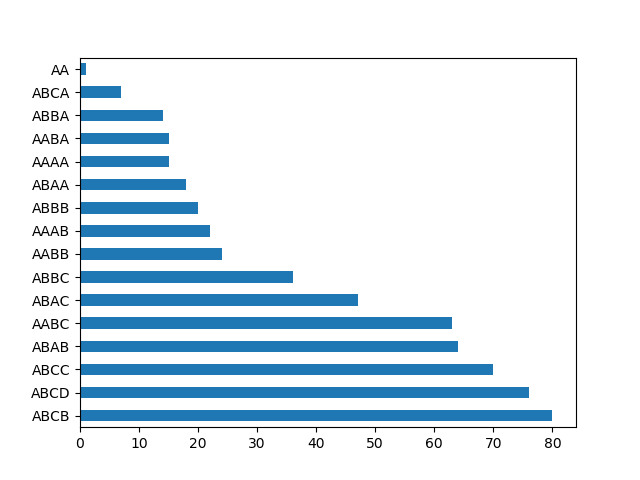

In [106]:
%matplotlib notebook
new_df.rhyme_scheme.value_counts().plot(kind = 'barh')

The most common one is "ABCB", but other rhyme schemes like "ABCD" "ABCC" are also quite frequent. Because Shakepeare's poems are mainly sonnets, this four-chunk method cannot deal with it very well. So inaccuracies are expected in this case. In fact, "ABCB" does not really match the rhyme schemes of Shakespearean sonnets ("ABAB CDCD EFEF GG"). The most reasonable one "ABAB" is only the forth most common one. Since the method I used fails to obtain a rhyme scheme roughly similar to the true ones, I decided not to apply the result to the poetry generation. 

Markov Chains

In [107]:
def Markov(poet):
    poet = nltk.word_tokenize(poet)
    poet = [x for x in poet if x not in "&[]()'‘’\"”“'d"]
    df2 = pd.DataFrame(ngram(poet))
    grouped_grams = df2.groupby(['Size','Gram','Word']).size()
    bigram = df2[df2.Size == 2].Gram.unique()
    capital_gram = [i for i in bigram if i[0][0].isupper()]
    return(capital_gram, grouped_grams)

capital_gram, grouped_grams = Markov(poet)
capital_gram[:10]

[('Let', 'the'),
 ('On', 'the'),
 ('Arabian', 'tree'),
 ('Herald', 'sad'),
 ('To', 'whose'),
 ('But', 'thou'),
 ('Foul', 'precurrer'),
 ('Augur', 'of'),
 ('To', 'this'),
 ('From', 'this')]

In [108]:
wordlist = list(random.choice(capital_gram)) # start with a random bigram that starts with a capital letter
word1 = wordlist[0]
word2 = wordlist[1]
for i in write_poem(10):
    print(i)

My flesh is a man . You hurt she meets 

title So let him a glorious 

morning , All the world s poor birds , nor boundless 

Since every day ? It shall be called the 

chronicle blasted , To clip makes him by Cupid 

that freeze both would peep acceptance 

hare hues thy face ; Slacked my state , And from As 

man , but live in thee , And lo hour Wherein 

I leave of their friends . Art pavement me my wound 

and quick fire . Sometime though of her way 



I also tried to put everything together into a function that takes in the name of a poet and returns 10 lines of poems similar to this poet's style.

In [111]:
def learn_style(poet):
    
    poet, df = get_poet(poet)
    
    #syllables
    n_syl, p = syllables(df)

    # rhyme scheme
    new_df = find_rhyme(df)
    
    # Markov chains
    capital_gram, grouped_grams = Markov(poet)

    wordlist = list(random.choice(capital_gram)) # start with a random bigram that starts with a capital letter
    word1 = wordlist[0]
    word2 = wordlist[1]
    for i in write_poem(10):
        print(i)

In [117]:
learn_style('William Blake')

//anaconda3/envs/Ling110/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


thy body s pure perfection with me , I 

am , and then lay Till , Thin blue And fright his tongue 

s forgeries , And farewell , But if that 

which it fears reckon , With hey , ho be , Die ever 

yet she replies : Finding ; and by Venus 

side to themselves in three ; Wound the day should 

have heard it can forbid on thee as stone 

at stirring ; And winking take my shadow 

in turning , Shall I think my breast ; Thou art 

more red each part , But if thou this to the 



## Conclusion

In this project, I tried to use the computer to "read" and "write" poems. Using unsupervised learning, it grouped poets into three clusters that represent different ages. Then I looked at John Milton's poems and wrote functions to obtain the metrical patterns and rhyme schemes of them. I compared the output with what we know about Milton’s poems to check whether the algorithm obtains their formal features successfully. The result shows that most of the lines have 10 syllables in each and do not use a rhyme scheme for every four-line chunk. Since Milton’s poems are mainly unrhymed iambic pentameter, it appears that the algorithm does work for him. For feet, the method I used to find stress patterns did not work well enough and therefore I decided not to use it for the generation. In the last section, I used Markov Chains to generate texts that incorporate the formal features of Milton’s poems. I also tried to apply the same process to other poets. While working with Shakespeare’s poems, I realized that the algorithm couldn’t effectively extract the rhyme schemes from his poems. So I chose not to generate Shakespearean poems using incorrect information.  

Even though I didn’t apply the rhyme schemes to the generation in the end, I have the information needed to do so. When I built the `grouped_grams` used for Markov Chains, I created a `rhyme_grams` that grouped the words by their last vowels. It allows me to select a word that follows a certain word/bigram and ends with a certain vowel. In this way, I can generate a four lines stanza each time and make sure the ending vowels of the last word in each line follow a certain rhyme scheme.   
    
Working with the project, I needed to face the trade-off between accuracy and feasibility. Sometimes it is difficult to find an ideal way to achieve the goals due to the complexity and uncertainty of situations. At this time, I had to use some crude methods that accomplish the task without taking care of every detail perfectly. Sometimes the results are satisfactory; but if the errors are significant, it may not be wise to use the results.   

In general, it is difficult for the computer to process information related to pronunciations because of irregularity and flexibility. So it may not be able to analyze prosody as well as humans. On the other hand, it can handle a large amount of text at the same time, while humans have to read line by line and determine the patterns for each poem. One can use it to explore the formal styles of hundreds of poets without having to read all the poems of each one. If we want to know something about the content, such as the subject matters, we can also perform topic modeling on poems and from the keywords associated with each topic determine the themes.   

It is interesting to teach the computer to write poems. Its process of “writing” is very different from humans writing. The computer simply puts words together in a designed way without knowing the meaning of them. It is for the reader to judge whether the output can be called a poem and give it meaning.